# Notebook to analyse leviation data
based on first version written by Aaron on May 16th 
written by Jan on May 21st
modified by Jan on May 23st
modified by Jan on May 31st
 
This is the master version of the notebook, this should always be the latest version!

# Instructions

This notebook analyses a video that measures a ring down experiment. 
For a new video:
    1. make a copy of this notebook
    2. rename the copy to reflect the name of the video that will be analyized (i.e. replace master in the ipynb name with the name of the video file)
    3. scroll down to settings and update
    4. execute cells
    (the first time you might want to active reencoding and extract position (section 1 and 2) and then deactivate it for future analyism ie only work with section after section 2)
    
Each section can be run independently. So to do one part of the analysis just go to the corresponding section
    
## Main output from this notebook

This notebook processes a video of levitated magnet motin and produces the following files:
    - a reencoded version of the video in case it got corrupted
    - .csv file with the xy-position data
    - info file with metadata about the dataset extracted from the video
    

    
   

#### load packages

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as sopt
# import pims
import scipy.spatial
import scipy.ndimage
from collections import Counter
import glob
from scipy.signal import find_peaks_cwt

import yaml, json
pix_to_um = 0.651 # conversion factor pixel to um
%matplotlib inline

# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2

# font settings for plots
font = {
    'size': 16
}
matplotlib.rc('lines', linewidth = 2)
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [9, 6]

os.sys.path.append('/Users/rettentulla/PycharmProjects/track_sphere/')
from track_sphere import plot_data as pltd


ModuleNotFoundError: No module named 'pims'

#### script execution settings

settings here determine which part of the notebook will be executed

In [2]:
# flag if video need to be reencoded if false the cell that reincodes the video will be skipped
# this is to avoid accidently running this cell which might take some time
reencode = False

# flag to extract position data from video
extract_position = True

##  Settings - update this section

#### 1a) filepaths

In [18]:
# set the path to the folder of the raw data
# Note that n the Alice computer we can't access the z-drive for some reason and
# thus copy the data to the c drive to work from there
# if original file was corrupted use the reencoded file (see point 0)
# filename_raw = 'C:\\Users\\Experiment\\Desktop\\tmp_data\\trapping_11_4\\ringdown_z_2_2_reencode.avi'
filename_raw = 'raw_data\\trapping_11_4\\ringdown_z_2_2_reencode.avi'
# target for processed data
# data and plots will be saved in a subfolder folder_path_processed/file_name,
# where file_name is the name of the video file
# don't forget the final \\!
# folder_path_processed = 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\'
folder_path_processed = 'processed_data\\trapping_11_4_batch\\'
#                         'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\'

In [19]:
# this dictionary keeps all the relevant information and will be updated as we extract more data
# finally it will be saved to the disc as a json file
# start by providing some meta data such as
#  info: some description of the measurement
#  tag:  a list of keywords that allow to identify the dataset
info = {
    'info': 'This video is part of the golden dataset',
    'tags':['golden dataset', 'single'],
    'extraction_nb':utils.get_notebook_name()
}

## Initialize

#### update info

In [81]:
info.update({
        'filename_raw': filename_raw,
        'folder_path_processed':folder_path_processed
})

info.update(cd.get_video_info(filename_raw))

#### set some varibales

In [20]:
filename_info = os.path.join(
            folder_path_processed,
            os.path.basename(filename_raw).replace('.avi',  '_info.json'))

## 1.) re-encode filename -  warning this can take a long time
if original file was corrupted reencode file

<span style="color:red">
**make sure that the subsequent sections have the right filenamen since filename_raw get overwritten here!**
</span>

In [14]:
# filename of original file
file_name_raw = 'C:\\Users\\Experiment\\Desktop\\tmp_data\\trapping_11_4\\ringdown_z_2_4.avi'
if reencode:
    cd.reencode_video(file_name_raw, filepath_target = None)

In [17]:
extract_position = True

## 2.) extract position information

### extract data

In [21]:
if extract_position:
    info.update(cd.extract_motion(filename_raw, target_path=folder_path_processed,  gaussian_filter_width=2,
                                  max_frames= 1e5))
else:
    # if position has been extracted previously, there should be an info file
    with open(filename_info, 'r') as infile:
        info_from_disk = yaml.safe_load(infile)
    
    for key in ['filename_xy_position', 'image_size', 'gaussian_filter_width', 'N_frames',
               'use_trackpy', 'start_time', 'end_time', 'max_frames'
               ]:
        info.update({key: info_from_disk[key]})
        
    if 'trackpy_parameters' in info_from_disk:
        info.update({'trackpy_parameters': info_from_disk['trackpy_parameters']})

start time:	2018-05-22 17:32:39
end time:	2018-05-22 17:35:12
file written to:
C:\Users\Experiment\Desktop\tmp_data\processed\trapping_11_4\ringdown_z_2_4_reencode_data_globalmax.csv


# save info to disk

In [82]:
with open(filename_info, 'w') as outfile:
    tmp = json.dump(info, outfile, indent=4)

## 3) Information about the video

#### load info

In [70]:
with open(filename_info, 'r') as infile:
    info = yaml.safe_load(infile)

### load the position data

In [71]:
filename_xy_position = info['filename_xy_position']

xy = cd.load_xy_time_trace(filename_xy_position, center_at_zero = False)

### 3a) show a few frames of the video to get an idea for what we are looking at

In [73]:
frames = [0]

# full image
xylim = None

# define dynamically 
image_size = 22
# image_size = 2*info['trackpy_parameters']['diameter']

# a, b = xylim
xylim = [
    [xy[frames[0]][0]-image_size/2, xy[frames[0]][0]+image_size/2],
    [xy[frames[0]][1]-image_size/2, xy[frames[0]][1]+image_size/2]
]


In [74]:
frames = [0, 1000]

#### no filter

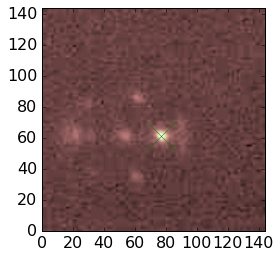

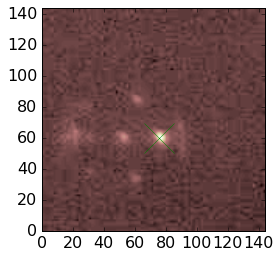

In [75]:
cd_plot.plot_video_frame(filename_raw, frames, xy_position = xy, gaussian_filter_width=None)

##### with filter

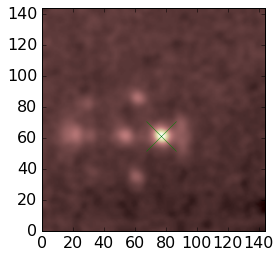

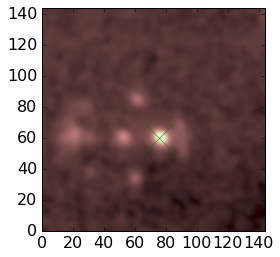

In [76]:
cd_plot.plot_video_frame(filename_raw, frames, xy_position = xy, gaussian_filter_width=2)

##### with filter and close up

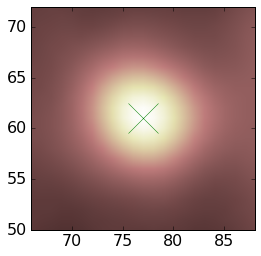

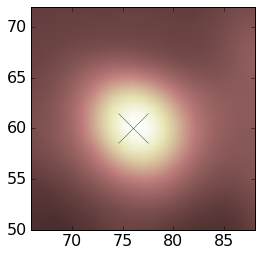

In [77]:
cd_plot.plot_video_frame(filename_raw, frames, xy_position = xy, gaussian_filter_width=2, xylim=xylim)

### 3b) show metadata

In [83]:
for k, v in info.iteritems():
    print(k, v)

('info', 'This video is part of the golden dataset')
('max_frames', 100000.0)
('use_trackpy', False)
('trackpy_parameters', {'diameter': 11, 'missing_frames': [], 'minmass': None})
('tags', ['golden dataset'])
('frame_rate', 600.0)
('start_time', '2018-05-22 17:32:39')
('N_frames', 2207079)
('filename_xy_position', 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\ringdown_z_2_4_reencode_data_globalmax.csv')
('filename_raw', 'C:\\Users\\Experiment\\Desktop\\tmp_data\\trapping_11_4\\ringdown_z_2_4_reencode.avi')
('end_time', '2018-05-22 17:35:12')
('gaussian_filter_width', 2)
('image_size', [144, 144])
('duration', 3678.465)
('folder_path_processed', 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\')


consisteny check

In [84]:
info['N_frames']/info['frame_rate'], info['duration']

(3678.465, 3678.465)

## 4) Look at timetraces

#### load info

In [ ]:
with open(filename_info, 'r') as infile:
    info = yaml.safe_load(infile)

In [60]:
dt = 1./info['frame_rate']

In [62]:
filename_xy_position = info['filename_xy_position']

xy = cd.load_xy_time_trace(filename_xy_position, center_at_zero = True)

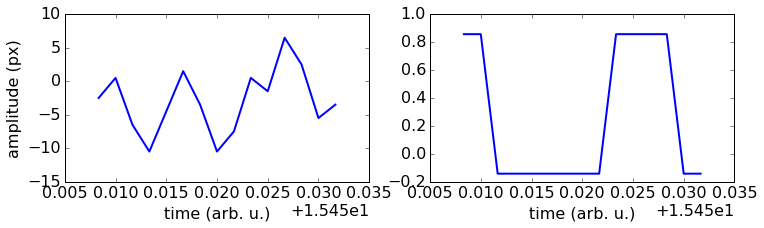

In [66]:

frames = np.arange(9275,9290)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize = (12,3))
ax1.plot(dt*frames, xy[frames,0])
ax2.plot(dt*frames, xy[frames,1])

ax1.set_xlabel('time (s)')
ax1.set_ylabel('amplitude (px)')
ax2.set_xlabel('time (s)')
# ax2.set_ylabel('amplitude (px)')

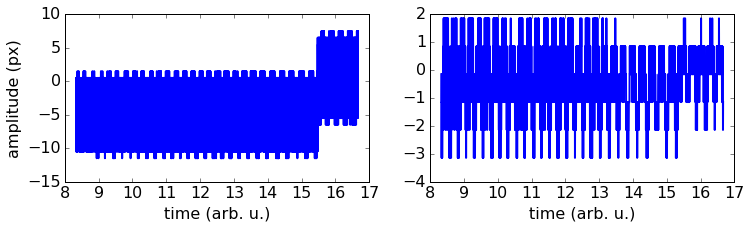

In [65]:
frames = np.arange(5000,10000)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize = (12,3))
ax1.plot(dt*frames, xy[frames,0])
ax2.plot(dt*frames, xy[frames,1])

ax1.set_xlabel('time (arb. u.)')
ax1.set_ylabel('amplitude (px)')
ax2.set_xlabel('time (arb. u.)')
# ax2.set_ylabel('amplitude (px)')

## 5) Look at power spectral densities (PSD)

In [95]:
mode_freq, mode_width = 140, 20
mode_f_min, mode_f_max = mode_freq-mode_width/2, mode_freq+mode_width/2

#### load info

In [96]:
with open(filename_info, 'r') as infile:
    info = yaml.safe_load(infile)
info

{'N_frames': 2207079,
 'duration': 3678.465,
 'end_time': '2018-05-22 17:35:12',
 'filename_raw': 'C:\\Users\\Experiment\\Desktop\\tmp_data\\trapping_11_4\\ringdown_z_2_4_reencode.avi',
 'filename_xy_position': 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\ringdown_z_2_4_reencode_data_globalmax.csv',
 'folder_path_processed': 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\',
 'frame_rate': 600.0,
 'gaussian_filter_width': 2,
 'image_size': [144, 144],
 'info': 'This video is part of the golden dataset',
 'max_frames': 100000.0,
 'start_time': '2018-05-22 17:32:39',
 'tags': ['golden dataset'],
 'trackpy_parameters': {'diameter': 11, 'minmass': None, 'missing_frames': []},
 'use_trackpy': False}

#### plot the psd as a function of time as a 2D plot

In [100]:
time_step = 1./info['frame_rate']

total number of frames:		100002
total number of windows:	33


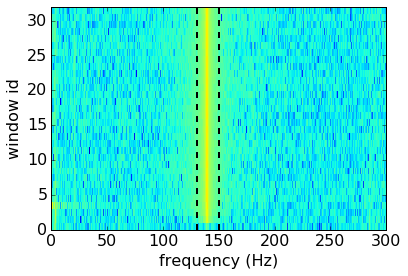

In [134]:
# start_frame = 100000
start_frame = 0 # starting frame for analysis
window_length = 3000 # length of window over which we compute the psd
end_frame = None # end frame for analysis (optional if None end_frame is len of total timetrace)
channel = 0 # channel 0=x, 1=y

# start script
cd_plot.plot_psd_vs_time(xy[:,channel],time_step=time_step,
                         start_frame = start_frame, window_length= window_length, end_frame = end_frame,
                         full_spectrum = True, 
                         frequency_range = [mode_f_min, mode_f_max])


In [137]:
range(40,50)

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

total number of frames:		100002
total number of windows:	100


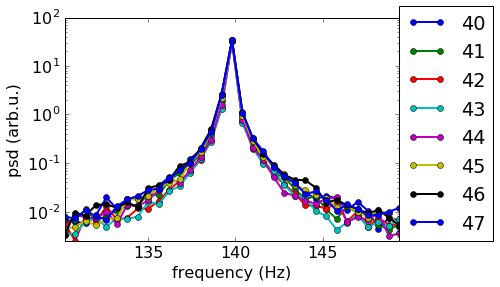

In [149]:
# start script
cd_plot.plot_psds(xy[:,channel],time_step=time_step,window_ids=range(40,48),
                         start_frame = start_frame, window_length= window_length, end_frame = end_frame,
                         full_spectrum = False, 
                         frequency_range = [mode_f_min, mode_f_max])

total number of frames:		100002
total number of windows:	100


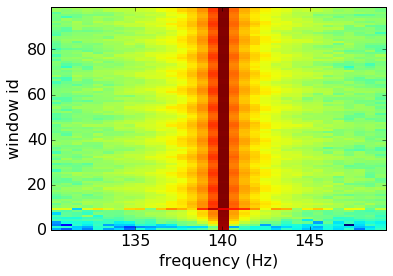

In [135]:
# start_frame = 100000
start_frame = 0 # starting frame for analysis
window_length = 1000 # length of window over which we compute the psd
end_frame = None # end frame for analysis (optional if None end_frame is len of total timetrace)
channel = 0 # channel 0=x, 1=y

# start script
cd_plot.plot_psd_vs_time(xy[:,channel],time_step=time_step,
                         start_frame = start_frame, window_length= window_length, end_frame = end_frame,
                         full_spectrum = False, 
                         frequency_range = [mode_f_min, mode_f_max])


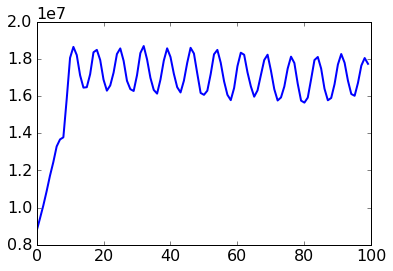

In [136]:
f_of_t, a_of_t = cd.get_freq_and_amp_timetrace(xy[:,channel], frequency_range = [mode_f_min, mode_f_max],
                              dt = time_step,nbin=window_length, velocity_type=True)
plt.plot(a_of_t)

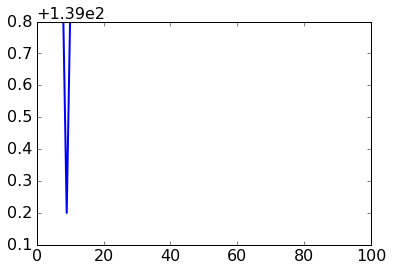

In [130]:
plt.plot(f_of_t)

# looking at the individual frames and playing around with the data

In [9]:
filename_raw = 'Z:\\Lab\\Lev\\videos\\20180322_LevSample_6\\20180529_Sample_6_bead_1\\20180529_Sample6_bead_1_direct_thermal_01.avi'

frames =[0, 1, 1000, 5000]

roi = [[63, 53], [15, 15]]

images = cd.get_frames(file_path=filename_raw, frames=frames, gaussian_filter_width=2, roi = roi)

In [10]:
np.shape(images)

(4L, 15L, 15L)

C:\ProgramData\Anaconda2\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


[nan, nan]
[-3.123860363907988, 32.2033142406121]
[9.977107934510666, 0.6872520812431031]
[14.084516593614262, -31.815405819447996]


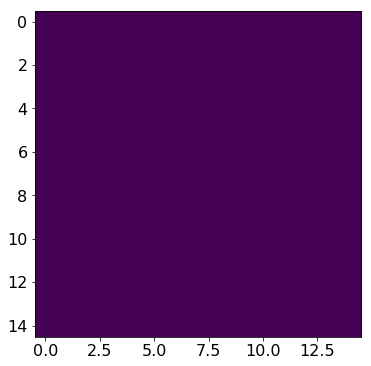

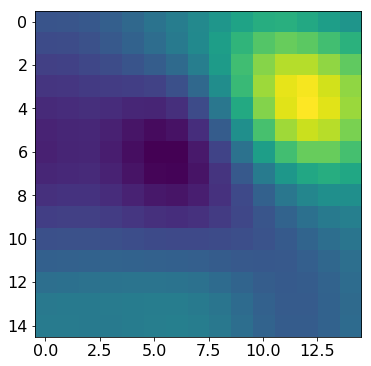

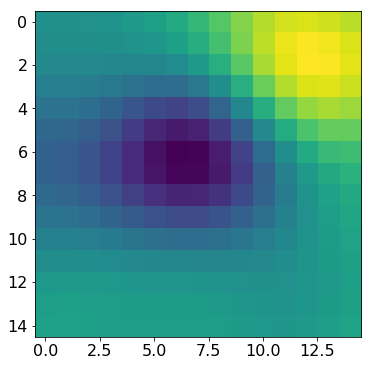

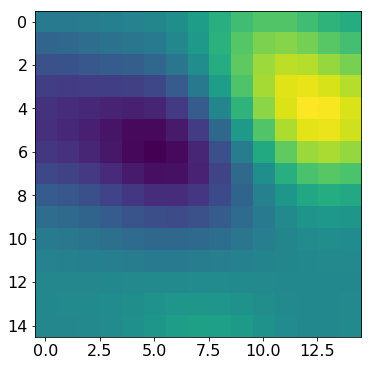

In [12]:
for image in images:
    plt.figure()
    img = image-images[0]
    plt.imshow(img)
    print(cd.get_center_of_mass(img))

# Using OpenCV - not finished

In [53]:
filename_raw = 'Z:\\Lab\\Lev\\videos\\20180322_LevSample_6\\20180529_Sample_6_bead_1\\20180529_Sample6_bead_1_direct_thermal_01_reencode_short.avi'

In [ ]:

import numpy as np
import cv2
cap = cv2.VideoCapture(filename_raw)
fgbg = cv2.createBackgroundSubtractorMOG2()
while(1):
    ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

# Playing around with Trackpy to get the position


In [28]:
import trackpy as tp

#### plot the first frame and the region of interest
The size of the circle shows the expected size of the spot

In [3]:
filename_raw = 'Z:\\Lab\\Lev\\videos\\20180322_LevSample_6\\20180529_Sample_6_bead_1\\20180529_Sample6_bead_1_direct_thermal_01.avi'
roi= [[60, 52], [31, 31]]

trackpy_parameters ={'diameter': 11, 'minmass': 3}

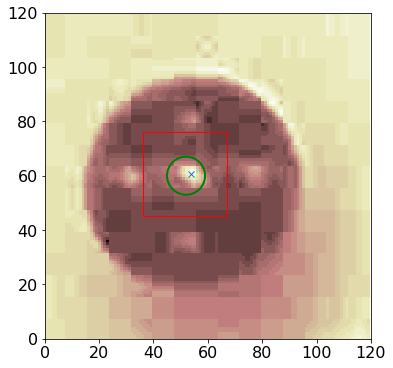

In [34]:
fig, ax = cd_plot.plot_video_frame(filename_raw, [0], xy_position = np.array([roi[0]]), gaussian_filter_width=None, xylim = None, roi = roi, ax = None, radius = (trackpy_parameters['diameter'])/2)

trackpy_parameters = {
    'diameter':15,
    'minmass': 2
}

locate_info = tp.locate(image, trackpy_parameters['diameter'], minmass=trackpy_parameters['minmass'])

ax[0].plot(locate_info['x'], locate_info['y'], 'x')

In [35]:
locate_info

,x,y,mass,size,ecc,signal,raw_mass,ep
0,53.874899,60.527323,2.831224,3.744289,0.17587,0.058534,16.152941,-1.284838


In [39]:
image_n

array([[185, 185, 185, ..., 208, 208, 197],
       [185, 185, 185, ..., 208, 208, 197],
       [185, 185, 185, ..., 208, 197, 197],
       ...,
       [185, 185, 185, ..., 208, 208, 208],
       [185, 185, 185, ..., 208, 208, 208],
       [185, 185, 185, ..., 208, 208, 208]])

In [44]:
image_i = plt.np.invert(image_n)

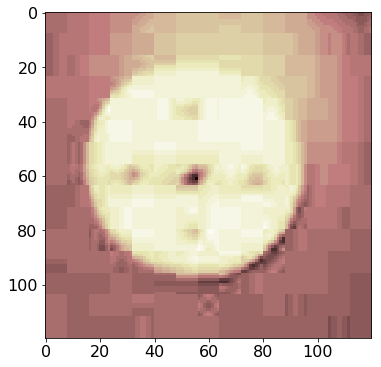

In [45]:
plt.imshow(image_i, cmap='pink')

In [15]:
filename_raw
import pims
from pims import pipeline
from skimage.color import rgb2gray
rgb2gray_pipeline = pipeline(rgb2gray)

In [33]:
?pims.Video

Init signature: pims.Video(self, filename, **kwargs)
Docstring:      <no docstring>
File:           c:\programdata\anaconda2\lib\site-packages\pims\imageio_reader.py
Type:           ABCMeta


In [8]:
v = pims.Video(filename_raw)

In [31]:
x = v[0]

In [34]:
np.sum(np.array(x[:,:,0])-np.array(x[:,:,2]))

0

In [18]:
video = pipeline(v)

AttributeError: 'ImageIOReader' object has no attribute '__name__'

In [17]:
video[0]

array([[0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.1372549 ],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.1372549 ],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.1372549 ,
        0.1372549 ],
       ...,
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.14117647],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.14117647],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.14117647]])

In [52]:
trackpy_parameters = {
    'diameter':11,
    'minmass': 1
}

locate_info = tp.locate(image, trackpy_parameters['diameter'], minmass=trackpy_parameters['minmass'])
locate_info

,x,y,mass,size,ecc,signal,raw_mass,ep
0,53.945659,60.716090,2.001705,3.030325,0.143738,0.054175,9.635294,1.264426
1,84.297470,87.418432,1.032720,3.253975,0.337779,0.026556,10.588235,0.384526
2,58.988948,99.857851,1.114938,3.206261,0.252844,0.024432,11.117647,0.277314


In [40]:
def normalize_to_byte(image):
    return (255*(image - np.min(image))/np.ptp(image)).astype(np.dtype('B'))

In [5]:
image = cd.get_frames(filename_raw, 0, gaussian_filter_width=None, roi = None)[0]

In [41]:
image_n =  normalize_to_byte(image)

,x,y,mass,size,ecc,signal,raw_mass,ep
0,53.874899,60.527323,2.831224,3.744289,0.17587,0.058534,16.152941,-1.284838


In [6]:
cd.get_position_trackpy(image_n, roi[0], trackpy_parameters=trackpy_parameters, verbose=True)

C:\ProgramData\Anaconda2\lib\site-packages\trackpy\feature.py:617: UserWarning: No maxima survived mass- and size-based prefiltering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0. See the documentation and the convenience function minmass_version_change.
  warnings.warn("No maxima survived mass- and size-based prefiltering. "


Empty DataFrame
Columns: [x, y, mass, size, ecc, signal, raw_mass, ep]
Index: []


In [27]:
trackpy_parameters = {
    'diameter':15,
    'minmass': 2
}

cd.get_position_trackpy(image_n, roi[0], trackpy_parameters=trackpy_parameters, verbose=True)

            x           y         mass      size       ecc     signal  \
0   59.966440   13.527104  1063.480582  4.351237  0.291292  14.354175   
1   52.137033   36.184933  2326.541339  3.395583  0.237034  54.063669   
2   12.557913   41.263432  4513.690151  4.430343  0.215418  61.887840   
3   94.433564   73.171972  4337.644791  4.350822  0.351226  67.319049   
4  110.446190   75.309216   499.294420  3.661851  0.207327  14.493086   
5   20.835104   85.931005  3986.914644  4.392865  0.197482  56.273630   
6   58.160406  100.377013  5847.203210  4.316282  0.302704  79.778688   

   raw_mass        ep  
0   12551.0  0.181856  
1    7810.0  0.527532  
2   24356.0  0.069105  
3   23602.0  0.071954  
4   27397.0  0.059588  
5   26089.0  0.063340  
6   26954.0  0.060807  


array([52.13703349, 36.18493339])

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(np.min(image), np.max(image)))
scaler = scaler.fit(image)
X_scaled = scaler.transform(image)

X_scaled


array([[0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.12810458],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.12810458],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.12810458,
        0.12810458],
       ...,
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.15686275]])

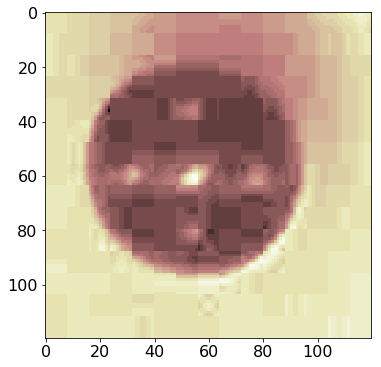

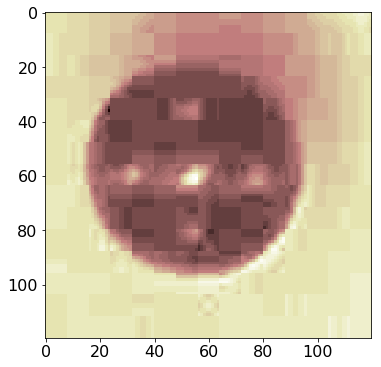

In [11]:
plt.imshow(image, cmap='pink')

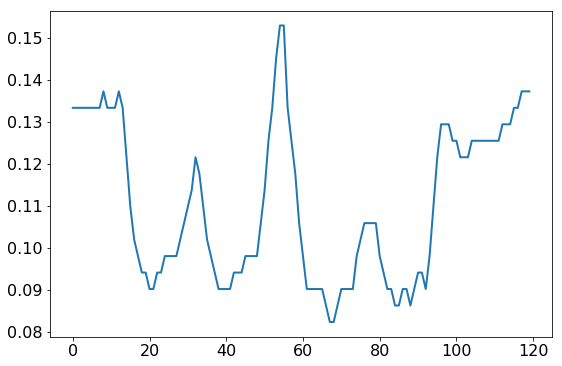

In [26]:
plt.plot(image[60])

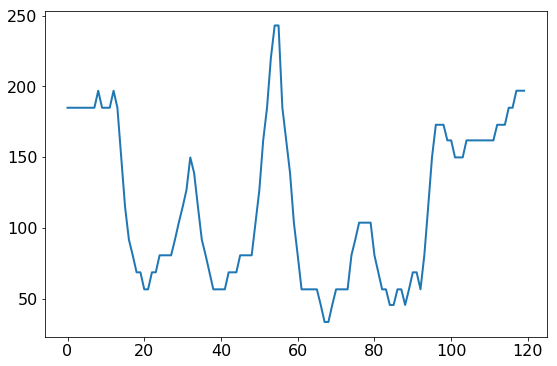

In [25]:
plt.plot(image_n[60])

In [24]:
np.min(image_n), np.max(image_n)

(0, 255)

In [35]:
import cv2 as cv

In [36]:
cv.__version__

'3.4.0'